In [1]:
root = "/silod8/karsten/new_work/runoff_prediction"
import os
os.chdir(root+"/preparation")

{'GoR_1': [{'lon': 23.7099, 'lat': 58.7527}], 'Kattegat_1': [{'lon': 11.097067832946777, 'lat': 53.974945068359375}], 'Skagerrak_1': [{'lon': 9.43041706085205, 'lat': 58.97487258911133}], 'BP_1': [{'lon': 13.874815940856934, 'lat': 53.974945068359375}], 'Skagerrak_2': [{'lon': 10.06, 'lat': 58.98}], 'BP_2': [{'lon': 14.26, 'lat': 53.95}], 'Skagerrak_3': [{'lon': 11.097067832946777, 'lat': 58.97487258911133}], 'BP_3': [{'lon': 14.985918045043945, 'lat': 53.974945068359375}], 'BP_4': [{'lon': 18.319217681884766, 'lat': 59.308189392089844}], 'Kattegat_2': [{'lon': 9.985967636108398, 'lat': 54.30828094482422}], 'Skagerrak_4': [{'lon': 10.54151725769043, 'lat': 59.308189392089844}], 'Kattegat_3': [{'lon': 12.208166122436523, 'lat': 54.30828094482422}], 'GoF_1': [{'lon': 23.874717712402344, 'lat': 59.308189392089844}], 'BP_5': [{'lon': 15.73, 'lat': 54.21}], 'GoF_2': [{'lon': 28.0, 'lat': 59.45}], 'BP_6': [{'lon': 18.93, 'lat': 54.35}], 'GoF_3': [{'lon': 25.1489, 'lat': 59.4779}], 'Kattegat_

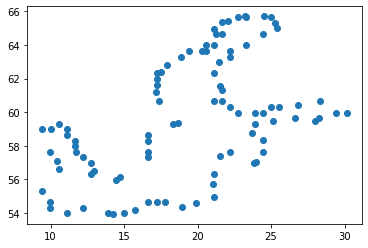

In [2]:
tmp = {}
import json
import glob
import xarray as xr

import numpy as np

import matplotlib.pyplot as plt

ehype_path = "/silod5/boergel/ocean_models_forcing/MOM_UERRA_FORCING/e-hype-runoff-raw/combined_fastriver_???.nc"

x = []
y = []

rivers = {}
counters = {}

for r in glob.glob(ehype_path):
    ds = xr.open_dataset(r)
    
    name = ds.roflux.basin 
    try:
        counters[name] += 1
    except:
        counters[name] = 1
    
    name += "_"+str(counters[name])
    
    lon = float(ds.roflux.lon)
    lat = float(ds.roflux.lat)
    
    ds.close()
    
    try:
        rivers[name].append({"lon" : lon, "lat" : lat})
    except:
        rivers[name] = [{"lon" : lon, "lat" : lat}]

    x.append(lon)
    y.append(lat)

plt.scatter(x,y)

with open("rivers.json", "w") as j:
    json.dump(rivers, j, indent=4)
print(rivers)

In [3]:
import os
grid_source = "/silod5/boergel/ocean_models_forcing/MOM_UERRA_FORCING/1961/rain.mom.dta.nc"

ds = xr.open_dataset(grid_source)
grid = xr.Dataset({"x" : (ds.x+1).astype(np.intc), "y" : (ds.y+1).astype(np.intc), "lon" : ds.lon.transpose(transpose_coords=True), "lat" : ds.lat.transpose(transpose_coords=True)})
#grid = xr.Dataset({"x" : ds.x, "y" : ds.y, "lon" : ds.lon, "lat" : ds.lat})
ds.close()

grid.to_netcdf("ROFF_grid.nc")



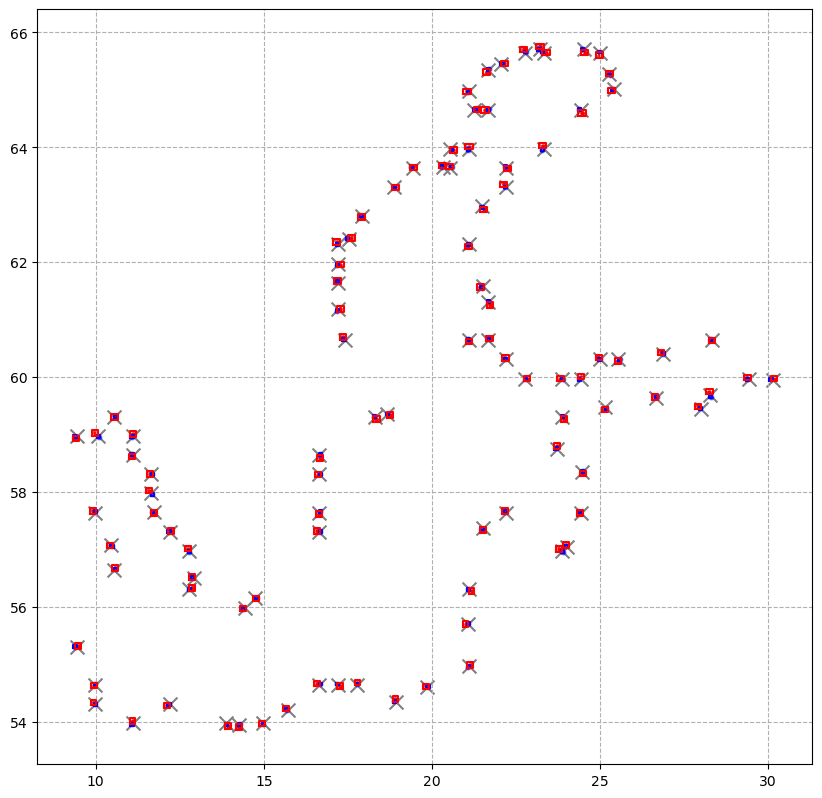

In [4]:
import json

with open("rivers.json") as f:
    rivers = json.load(f)
    
grids = ["MOM5_Baltic/t_grid.nc", "ROFF_Baltic/t_grid.nc"]

model_points = {}

for r in rivers:
    model_points[r] = {}

plot_args = {"MOM5_Baltic" :  { "s" : 10, "alpha" : 0.5, "color" : "blue" }, "ROFF_Baltic" : { "s" : 5, "color" : "red"} }

plt.figure(figsize=(10,10), dpi=100)

river_x = []
river_y = []
for r in rivers.keys():
    for p in rivers[r]:
        river_x.append(p["lon"])
        river_y.append(p["lat"])
        
plt.scatter(river_x, river_y, color="grey", marker="x", s=100)

for g in grids:
    ds = xr.open_dataset(g)
    lons = ds["grid_center_lon"].data
    corner_lons = ds["grid_corner_lon"].data
    lats = ds["grid_center_lat"].data
    corner_lats = ds["grid_corner_lat"].data
    grid_dims = ds["grid_dims"].data
    ds.close()
    
    model = g.split("/")[-2]
    
    x = []
    y = []
    
    for r in rivers.keys():
        model_points[r][model] = []
        for p in rivers[r]:
            lon = p["lon"]
            lat = p["lat"]
                
            n = int(((lons - lon)**2 + (lats - lat)**2).argmin())
            
            if len(grid_dims) == 2:
                i = int(n%grid_dims[0])
                j = int(n//grid_dims[0])
                model_points[r][model].append({"i" : i, "j" : j})
                
            elif len(grid_dims) == 1:
                i = int(((lons - lon)**2 + (lats - lat)**2).argmin())
                j = 0
                model_points[r][model].append({"i" : i})
        
                
            x.append(lons[j*grid_dims[0]+i])
            y.append(lats[j*grid_dims[0]+i])  
                
            polygon = []
                
            for k, c in enumerate(corner_lons[j*grid_dims[0]+i]):
                if c > -1000.0:
                    polygon.append([corner_lons[j*grid_dims[0]+i][k], corner_lats[j*grid_dims[0]+i][k]])
                    
            polygon.append(polygon[0])
            xs, ys = zip(*polygon)
            plt.plot(xs, ys, color=plot_args[model]["color"])
                
            
                
    plt.scatter(x,y, **plot_args[model])
    #plt.xlim([10,15])
    #plt.ylim([54,60])
    plt.grid(linestyle="--")
                
#print(model_points)
            
with open("model_points.json", "w") as f:
    json.dump(model_points, f, indent=4)
    
# specify the variable "ROFF" with direct links from model "MOM5_Baltic" to model "ROFF_Baltic"
direct_links = {"ROFF" : {"from" : "ROFF_Baltic", "to" : "MOM5_Baltic"}}
for r in model_points:
    
    for m in model_points[r].keys():
        try:
            direct_links["ROFF"][m] += model_points[r][m]
        except:
            direct_links["ROFF"][m] = model_points[r][m]
            

with open("direct_links.json", "w") as f:
    json.dump(direct_links, f, indent=4)